In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load datasets
train_df= pd.read_csv('./data/train.csv')
test_df= pd.read_csv('./data/test.csv')

# Display all columns
pd.set_option('display.max_columns', None)

# One-hot encoding or label encoding
train_encoded = pd.get_dummies(train_df, drop_first=True)
test_encoded = pd.get_dummies(test_df, drop_first=True)

# create target column
train_encoded['Attrition_Yes'] = 1 - train_encoded['Attrition_Stayed']
test_encoded['Attrition_Yes'] = 1 - test_encoded['Attrition_Stayed']
train_encoded = train_encoded.drop('Attrition_Stayed', axis=1)
test_encoded = test_encoded.drop('Attrition_Stayed', axis=1)

X_train = train_encoded.drop('Attrition_Yes', axis=1)
y_train = train_encoded['Attrition_Yes']

X_test = test_encoded.drop('Attrition_Yes', axis=1)
y_test = test_encoded['Attrition_Yes']

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [5]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_log))
print(confusion_matrix(y_test, y_pred_log))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      7868
           1       0.73      0.76      0.74      7032

    accuracy                           0.75     14900
   macro avg       0.75      0.75      0.75     14900
weighted avg       0.75      0.75      0.75     14900

[[5902 1966]
 [1716 5316]]


In [8]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)  # No scaling needed for trees
y_pred_rf = rf_model.predict(X_test)

print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


Random Forest Results:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      7868
           1       0.74      0.72      0.73      7032

    accuracy                           0.75     14900
   macro avg       0.75      0.75      0.75     14900
weighted avg       0.75      0.75      0.75     14900

[[6101 1767]
 [1974 5058]]


In [9]:
from xgboost import XGBClassifier

# Train XGBoost
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate
print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost Results:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      7868
           1       0.73      0.74      0.74      7032

    accuracy                           0.75     14900
   macro avg       0.75      0.75      0.75     14900
weighted avg       0.75      0.75      0.75     14900

[[5978 1890]
 [1843 5189]]


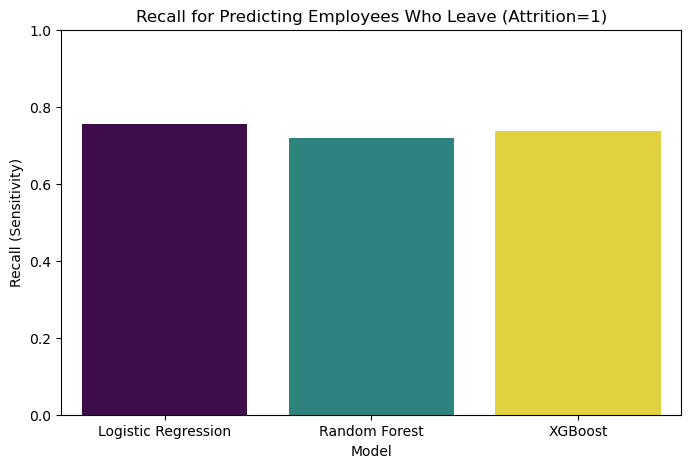

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score

# Suppose you have predictions from your 3 models:
# y_pred_log, y_pred_rf, y_pred_xgb (already predicted on y_test)
# And y_test is your true labels

# Calculate recall for the positive class (1) for each model
recall_log = recall_score(y_test, y_pred_log, pos_label=1)
recall_rf = recall_score(y_test, y_pred_rf, pos_label=1)
recall_xgb = recall_score(y_test, y_pred_xgb, pos_label=1)

# Prepare data for plotting
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']
recall_scores = [recall_log, recall_rf, recall_xgb]

plt.figure(figsize=(8,5))
sns.barplot(x=model_names, y=recall_scores, palette='viridis', hue = x, legend=False)

plt.title('Recall for Predicting Employees Who Leave (Attrition=1)')
plt.ylabel('Recall (Sensitivity)')
plt.ylim(0,1)
plt.xlabel('Model')
plt.show()

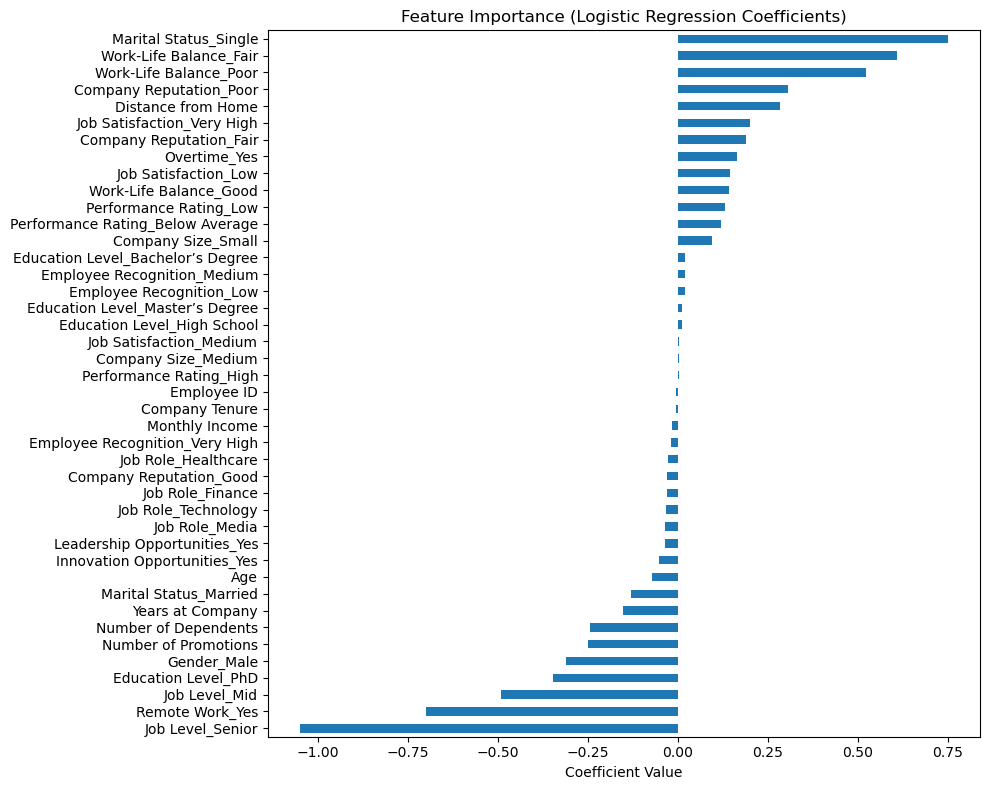

In [16]:
coefficients = pd.Series(log_model.coef_[0], index=X_train.columns)
coefficients.sort_values().plot(kind='barh', figsize=(10, 8))
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

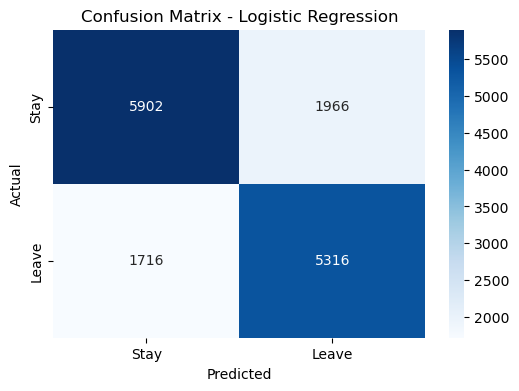

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions from logistic regression
y_pred = log_model.predict(X_test_scaled)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Stay", "Leave"], yticklabels=["Stay", "Leave"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

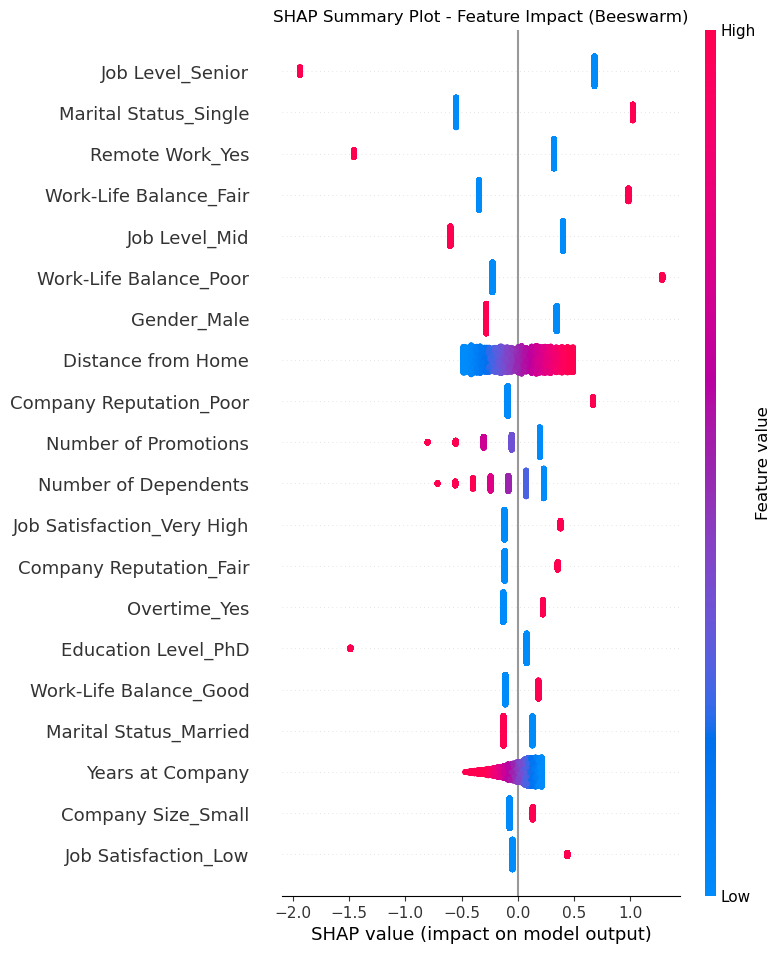

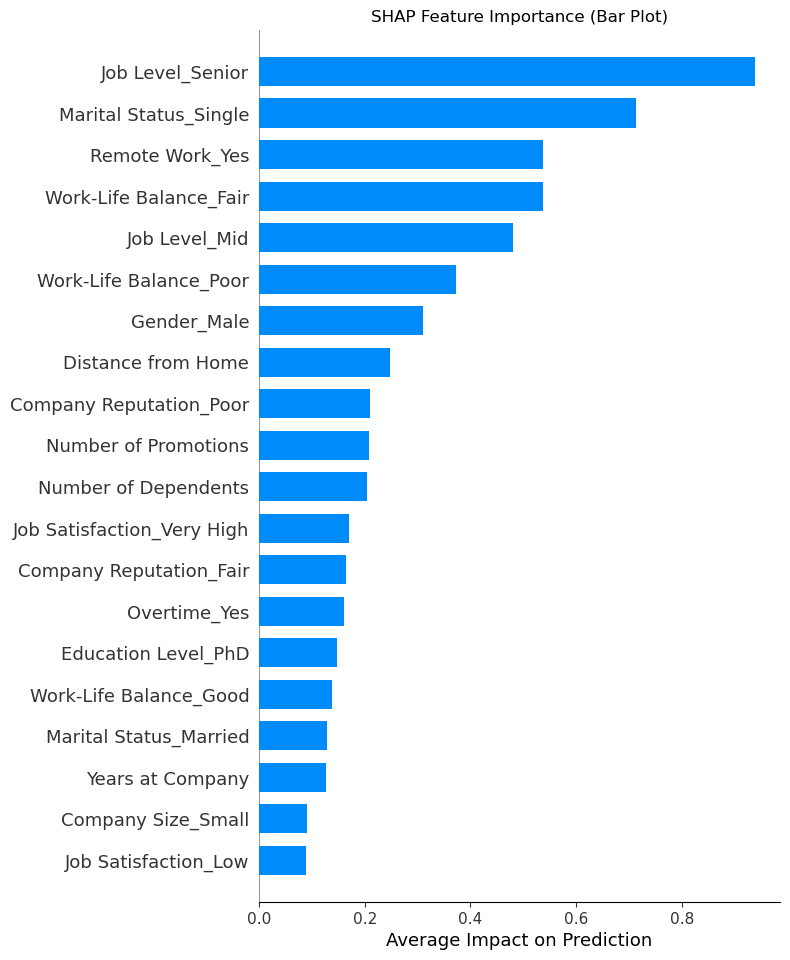

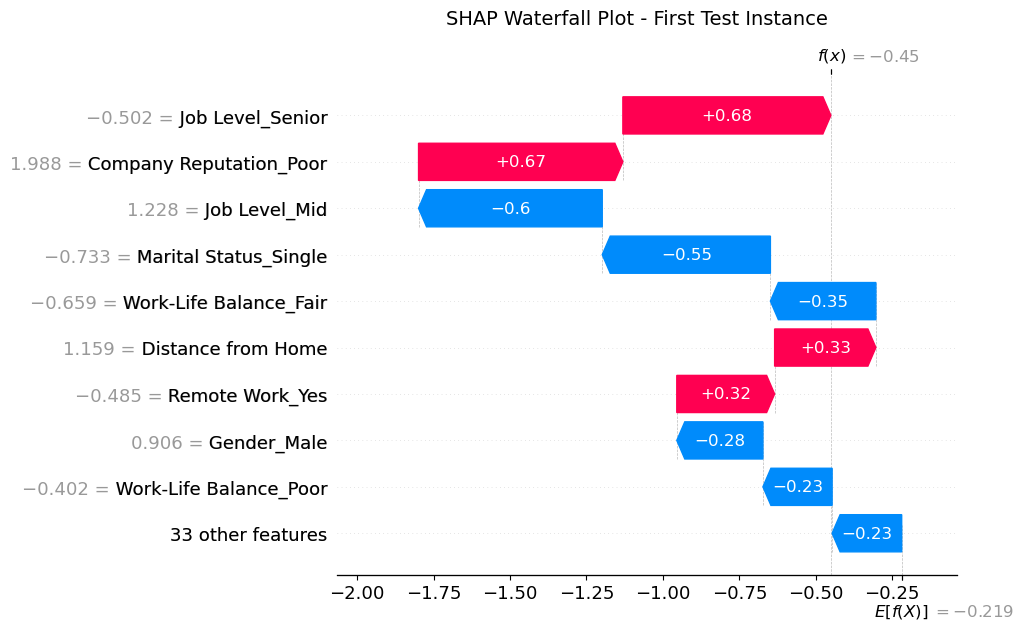

In [22]:
import shap
import matplotlib.pyplot as plt

# Create SHAP explainer for logistic regression
explainer = shap.LinearExplainer(log_model, X_train_scaled)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot (beeswarm)
plt.figure()
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns, show=False)
plt.title("SHAP Summary Plot - Feature Impact (Beeswarm)")
plt.show()

# --- Bar plot (average absolute importance) ---
plt.figure()
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Bar Plot)")
plt.xlabel("Average Impact on Prediction")
plt.show()

# --- Waterfall plot for first test instance ---
plt.figure()
plt.suptitle("SHAP Waterfall Plot - First Test Instance", fontsize=14)
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=X_test_scaled.iloc[0],
        feature_names=X_train.columns
    )
)
plt.show()

In [26]:
import joblib

# Save the logistic regression model
joblib.dump(log_model, 'models/logistic_model.joblib')

# Save the scaler
joblib.dump(scaler, 'models/scaler.joblib')

# Save feature columns
joblib.dump(X_train.columns.tolist(), 'models/model_columns.joblib')

['models/model_columns.joblib']